In [1]:
!pip install scikit-learn sounddevice matplotlib glob2 tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 26.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 4.9 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, concatenate, Concatenate, LSTM, Dense, SimpleRNN, BatchNormalization, Dropout, BatchNormalization, Add, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, Dropout, MultiHeadAttention, Conv2D, Conv2DTranspose, MaxPooling2D, Permute, Reshape

# import sounddevice as sd
import os
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import wavfile
from glob2 import glob
from tqdm import tqdm

2023-05-09 21:23:41.619553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

gpu=tf.test.gpu_device_name()
if gpu=="":
  print("Computador sem GPU.")
else:
  print("Computador com GPU:",tf.test.gpu_device_name())
  from tensorflow.python.client import device_lib
  devices=device_lib.list_local_devices()
  print("Dispositivos:",[x.physical_device_desc for x in devices if x.physical_device_desc!=""])
print()

!lsb_release -a | grep "Description" #imprime qual é o sistema operacional
!echo

!cat /proc/cpuinfo | grep -E "model name|core" #especificações de CPU
!echo 

!cat /proc/meminfo  | grep "Mem" #especificações de RAM

TPU not found
Computador com GPU: /device:GPU:0
Dispositivos: ['device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1']



2023-05-09 21:23:54.209875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-09 21:23:54.291062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-09 21:23:54.291617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

No LSB modules are available.
Description:	Ubuntu 20.04.5 LTS

model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 0
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 1
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 2
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 3
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 4
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 5
cpu cores	: 6

MemTotal:       16334184 kB
MemFree:        11124560 kB
MemAvailable:   13401572 kB


In [4]:
def calcular_componentes_fourier(sinal):
    componentes = np.fft.fft(sinal)
    # Obter a magnitude máxima dos componentes
    max_magnitude = np.max(np.abs(componentes), axis=1).reshape(-1, 1)
    # Normalizar os componentes para o intervalo [-1, 1]
    componentes_normalizados = componentes / max_magnitude
    
    res = np.stack((np.real(componentes_normalizados), np.imag(componentes_normalizados)), axis=2)

    return np.array(res), max_magnitude

def reconstruir_sinal(componentes, max_magnitude):
    comp = componentes[:, :, 0] + 1j * componentes[:, :, 1]
    print(comp.shape)
    sinal_reconstruido = np.fft.ifft(comp) * max_magnitude
    return np.real(sinal_reconstruido)

In [5]:
def undersample_signal_with_antialiasing(sound, orig_sr, desired_sr):
    
    new_sound = sound.copy()
    
    nyq = 0.5 * orig_sr
    cutoff_freq = desired_sr /2
    order = 6
    normal_cutoff = cutoff_freq / nyq

    # Compute the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    sound = filtfilt(b, a, new_sound)

    target_size = int(len(new_sound)*desired_sr/orig_sr)
    downsampled_signal = resample(new_sound, target_size)

    return downsampled_signal

In [6]:
def get_sounds_from_folder(path):
    
    max_depth = 3  # replace with the maximum depth of subfolders to search

    sound_list = []

    for root, dirs, files in os.walk(path):
        depth = root[len(path) + len(os.path.sep):].count(os.path.sep)
        if depth < max_depth:
            for file in files:
                if file.endswith('.bin'):#or file.endswith('.bin'):
                    wav_path = os.path.join(root, file)
                    sound_list.append(wav_path)
    
    return sound_list

In [7]:
def load_wav(filename):
    # Load the WAV file
    sample_rate, data = wavfile.read(filename)

    # Convert the data to float32 values between -1 and 1
    data = np.float32(data / 32767.0)
    return data

In [8]:
def load_sound_from_bin(bin_path):
    # Carrega arquivo inteiro formato DOS
    # de nome contido na string str na variável x

    # with open(bin_path, 'rb') as f:
    #     x = np.fromfile(f, dtype=np.uint16)

    # supu = 2 ** 16  # 'supremo' unsigned
    # supc = 2 ** 15  # 'supremo' complemento de dois

    # nx = len(x)
    # x = 256 * x[1:nx:2] + x[0:nx:2]
    # i = np.where(x >= supc)[0]  # amostras que devem ser complementadas
    # x[i] = x[i] - supu

    # # return x, i
    # return uint16_to_int16(x)

    with open(bin_path, 'rb') as f:
        # Read the binary data as a string
        data = f.read()

    # Convert the string to a numpy int16 array
    array = np.frombuffer(data, dtype=np.int16)
    return array.astype(np.float32) / 32768.0

In [9]:
def add_white_gaussian_noise(signal, snr):
    # Calculate the signal power and convert to dB
    signal_power = np.mean(signal**2)
    signal_power_db = 10 * np.log10(signal_power)

    # Calculate the noise power required for the specified SNR and convert to linear scale
    noise_power_db = signal_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    # Generate random noise with the required power and add it to the signal
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    noisy_signal = signal + noise

    return noisy_signal

In [10]:
def calculate_snr(clean_signal, noisy_signal):
    """
    Calculate the signal-to-noise ratio (SNR) in dB between a clean signal and a noisy signal.
    
    Args:
    clean_signal (numpy array): clean signal of shape (N, 1)
    noisy_signal (numpy array): noisy signal of shape (N, 1)
    
    Returns:
    snr_db (float): signal-to-noise ratio (SNR) in dB
    """
    clean_signal = clean_signal.reshape(-1, 1)
    noisy_signal = noisy_signal.reshape(-1, 1)
    
    # Calculate the power of the clean signal
    clean_power = np.mean(clean_signal ** 2)
    
    # Calculate the power of the noise signal
    noise_signal = noisy_signal - clean_signal
    noise_power = np.mean(noise_signal ** 2)
    
    # Calculate the SNR in dB
    snr_db = 10 * np.log10(clean_power / noise_power)
    
    return snr_db

In [11]:
def calculate_snrseg(clean_signal, noisy_signal, segment_size):
    """
    Calculate the signal-to-noise ratio (SNR) using the SNRseg metric between a clean signal and a noisy signal.
    
    Args:
    clean_signal (numpy array): clean signal of shape (N, 1)
    noisy_signal (numpy array): noisy signal of shape (N, 1)
    segment_size (int): size of each segment
    
    Returns:
    snr_db (float): signal-to-noise ratio (SNR) using the SNRseg metric
    """
    clean_signal = clean_signal.reshape(-1,1)
    noisy_signal = noisy_signal.reshape(-1,1)
    
    # Calculate the number of segments
    num_segments = int(np.floor(len(clean_signal) / segment_size))
    
    # Calculate the power of the clean signal
    clean_power = np.mean(clean_signal ** 2)
    
    # Initialize the noise power and segment count
    noise_power = 0
    segment_count = 0
    
    # Calculate the power of the noise signal for each segment
    for i in range(num_segments):
        segment_start = i * segment_size
        segment_end = (i+1) * segment_size
        noise_signal = noisy_signal[segment_start:segment_end] - clean_signal[segment_start:segment_end]
        noise_power += np.mean(noise_signal ** 2)
        segment_count += 1
        
    # Calculate the average noise power over all segments
    noise_power = noise_power / segment_count
    
    # Calculate the SNR using the SNRseg metric
    snr_db = 10 * np.log10(clean_power / noise_power)
    
    return snr_db

In [12]:
sound_path = './Base'

In [13]:
folders = os.listdir(sound_path)

In [106]:
base_shape_size = 1024

In [ ]:
sound_array_clean = np.empty((1, base_shape_size, 2), np.float32)
sound_array_noisy = np.empty((1, base_shape_size, 2), np.float32)

for folder in tqdm(folders[:30]):
    current_sound_folder = os.path.join(sound_path, folder)

    file_pattern = '*clean.wav'
    clean_files = glob(os.path.join(current_sound_folder, file_pattern))
    
    for file in clean_files[:5]:
        # para cada clean file, carregar na base
        clean_sound = load_wav(file)
        clean_components, _ = calcular_componentes_fourier(clean_sound[:len(clean_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size))
        
        # Check se tem número maior que 1
        flattened_arr = clean_components.reshape(-1, 1)
        # Get the top 5 maximum numbers
        if np.sum(flattened_arr > 1) > 0 or np.sum(flattened_arr < -1) > 0:
            continue

        clean_name = os.path.basename(file).split('_')[0]
        noisy_pattern = clean_name + '_{}_{}.wav'
        
        for i in range(-5, 11):
            for j in range(1, 3):
                noisy_path = os.path.join(current_sound_folder, noisy_pattern.format(i, j))
                noisy_sound = load_wav(noisy_path)

                noisy_components, _ = calcular_componentes_fourier(noisy_sound[:len(noisy_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size))
                
                # Check se tem número maior que 1
                flattened_arr_n = noisy_components.reshape(-1, 1)
                if np.sum(flattened_arr_n > 1) > 0 or np.sum(flattened_arr_n < -1) > 0:
                    continue
                
                sound_array_noisy = np.append(sound_array_noisy, noisy_components, axis=0)
                sound_array_clean = np.append(sound_array_clean, clean_components, axis=0)

 73%|████████████████████████████████████████████████████████████████████████████████████████▋                                | 22/30 [07:12<04:24, 33.12s/it]

In [ ]:
# Define the proportion of data to use for training, validation, and test
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2

sound_array_clean = np.nan_to_num(sound_array_clean, nan=0.0)
sound_array_noisy = np.nan_to_num(sound_array_noisy, nan=0.0)

In [ ]:
# Split the data and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sound_array_noisy, sound_array_clean, test_size=test_prop)

# Split the training data and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_prop/train_prop)

In [ ]:
X_train = np.clip(X_train, -1, 1)
X_val = np.clip(X_val, -1, 1)
y_train = np.clip(y_train, -1, 1)
y_val = np.clip(y_val, -1, 1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

In [ ]:
print(np.max(X_train))
print(np.max(y_train))
print(np.max(X_val))
print(np.max(y_val))

In [ ]:
print(np.min(X_train))
print(np.min(y_train))
print(np.min(X_val))
print(np.min(y_val))

In [ ]:
def attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)
    f = Activation('relu')(Add()([theta_x, phi_g]))
    psi_f = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(f)
    rate = Activation('sigmoid')(psi_f)
    att_x = Multiply()([x, rate])
    return att_x

def residual_block(x, channels):
    conv1 = Conv1D(channels, (3, 3), activation='relu', padding='same')(x)
    conv2 = Conv1D(channels, (3, 3), activation='relu', padding='same')(conv1)
    residual = Add()([x, conv2])
    return residual

def unet_with_residual_and_attention(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    conv1 = residual_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = residual_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bridge
    conv5 = residual_block(pool4, 1024)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    att6 = attention_block(conv4, up6, 512)
    merge6 = Concatenate()([att6, up6])
    conv6 = residual_block(merge6, 512)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    att7 = attention_block(conv3, up7, 256)
    merge7 = Concatenate()([att7, up7])
    conv7 = residual_block(merge7, 256)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    att8 = attention_block(conv2, up8, 128)
    merge8 = Concatenate()([att8, up8])
    conv8 = residual_block(merge8, 128)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    att9 = attention_block(conv1, up9, 64)
    merge9 = Concatenate()([att9, up9])
    conv9 = residual_block(merge9, 64)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def unet(inputs):
  # Encoder
    conv1 = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv1D(64, 3, activation='relu', padding='same')(conv1)
    # conv1 = BatchNormalization()(conv1)
    # att1 = Attention()(conv1)
    # conv1 = Multiply()([conv1, att1])
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv1D(128, 3, activation='relu', padding='same')(conv2)
    # conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv1D(256, 3, activation='relu', padding='same')(conv3)
    # conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    conv4 = Conv1D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv1D(512, 3, activation='relu', padding='same')(conv4)
    # conv4 = BatchNormalization()(conv4)
    # att2 = Attention()(conv4)
    # conv4 = Multiply()([conv4, att2])
    pool4 = MaxPooling1D(pool_size=2)(conv4)

    conv5 = Conv1D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv1D(1024, 3, activation='relu', padding='same')(conv5)
    # conv5 = BatchNormalization()(conv5)

    # Decoder
    up6 = concatenate([Conv1DTranspose(1, 1, strides=2)(conv5), conv4], axis=-1)
    conv6 = Conv1D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv1D(512, 3, activation='relu', padding='same')(conv6)
    # conv6 = BatchNormalization()(conv6)
    # conv6 = Add()([conv6, conv4])

    up7 = concatenate([Conv1DTranspose(1, 1, strides=2)(conv6), conv3], axis=-1)
    conv7 = Conv1D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv1D(256, 3, activation='relu', padding='same')(conv7)
    # conv7 = BatchNormalization()(conv7)
    # conv7 = Add()([conv7, conv3])

    up8 = concatenate([Conv1DTranspose(1, 1, strides=2)(conv7), conv2], axis=-1)
    conv8 = Conv1D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv1D(128, 3, activation='relu', padding='same')(conv8)
    # conv8 = BatchNormalization()(conv8)
    # conv8 = Add()([conv8, conv2])

    up9 = concatenate([Conv1DTranspose(1, 1, strides=2)(conv8), conv1], axis=-1)
    conv9 = Conv1D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv1D(64, 3, activation='relu', padding='same')(conv9)
    # conv9 = BatchNormalization()(conv9)

    # Output
#     outputs = Conv1D(2, 1, activation='tanh')(conv9)
    flat = Flatten()(outputs)
    den = Dense(base_shape_size * 2, 'tanh')(flat)
    outputs = Reshape((base_shape_size, 2))(den)

    return outputs

In [ ]:
from tensorflow.keras.layers import ActivityRegularization

def long_model():
    inputs = Input((base_shape_size, 2))

    unet1 = unet(inputs)
    unet1 = Dropout(0.3)(unet1)
    add1 = Add()([inputs, unet1])
#     add1 = ActivityRegularization(l1=0.01)(add1)

    unet2 = unet(add1)
#     add2 = Add()([add1, unet2])
#     add2 = ActivityRegularization(l1=0.01)(add2)
    
#     unet3 = unet(add2)
#     add3 = Add()([add2, unet3])
#     add3 = ActivityRegularization(l1=0.01)(add3)
    
#     outputs = Conv1D(2, 1, activation='tanh')(add3)
    
    return Model(inputs=inputs, outputs=unet2)

In [102]:
y_train.shape

(3379, 8400, 2)

In [103]:
class PlotLossesCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.epochs = 0
        self.fig, self.ax = plt.subplots()

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.epochs += 1

        self.ax.clear()
        self.ax.plot(range(1, self.epochs+1), self.losses, label='training')
        self.ax.plot(range(1, self.epochs+1), self.val_losses, label='validation')
        self.ax.legend()
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.set_title('Training and Validation Loss')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 8400, 2)]    0           []                               
                                                                                                  
 conv1d_279 (Conv1D)            (None, 8400, 64)     448         ['input_9[0][0]']                
                                                                                                  
 conv1d_280 (Conv1D)            (None, 8400, 64)     12352       ['conv1d_279[0][0]']             
                                                                                                  
 max_pooling1d_60 (MaxPooling1D  (None, 4200, 64)    0           ['conv1d_280[0][0]']             
 )                                                                                          

                                                                                                  
 conv1d_299 (Conv1D)            (None, 8400, 64)     12352       ['conv1d_298[0][0]']             
                                                                                                  
 max_pooling1d_64 (MaxPooling1D  (None, 4200, 64)    0           ['conv1d_299[0][0]']             
 )                                                                                                
                                                                                                  
 conv1d_300 (Conv1D)            (None, 4200, 128)    24704       ['max_pooling1d_64[0][0]']       
                                                                                                  
 conv1d_301 (Conv1D)            (None, 4200, 128)    49280       ['conv1d_300[0][0]']             
                                                                                                  
 max_pooli

2023-05-10 02:12:25.046465: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 131.25MiB (rounded to 137625600)requested by op model_4/conv1d_285/Conv1D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-10 02:12:25.046610: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-05-10 02:12:25.046656: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 266, Chunks in use: 265. 66.5KiB allocated for chunks. 66.2KiB in use in bin. 21.8KiB client-requested in use in bin.
2023-05-10 02:12:25.046689: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 126, Chunks in use: 126. 63.0KiB allocated for chunks. 63.0KiB in use in bin. 63.0KiB client-requested in use in bin.
2023-05-10 02:12:25.046722: I 

ResourceExhaustedError: Graph execution error:

Detected at node 'model_4/conv1d_285/Conv1D' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_7673/1141627699.py", line 13, in <module>
      model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[PlotLossesCallback()])
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model_4/conv1d_285/Conv1D'
OOM when allocating tensor with shape[64,512,1,1050] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/conv1d_285/Conv1D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_194648]

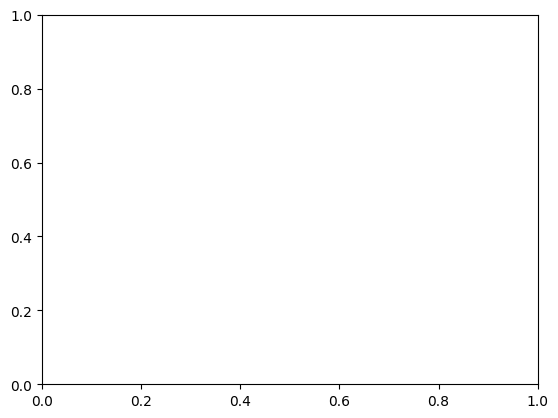

In [104]:
from tensorflow.keras.losses import MeanSquaredError, MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import Adam

# model = my_model()
model = long_model()
model.summary()

# Compile the model with a specific learning rate
learning_rate = 3e-2
optimizer = Adam()

model.compile(optimizer='adam', loss=MeanSquaredLogarithmicError(),)
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=[PlotLossesCallback()])

score = model.evaluate(X_test, y_test, verbose=0)
print(score)
model.save('temp.h5')

In [ ]:
sound = load_wav('./Base/BR_00400/balsen3_clean.wav')
sound_array_clean = sound[:len(sound) // 256 * 256].reshape(-1, 256)

noisy_sound = load_wav('./Base/BR_00400/balsen3_10_1.wav')
sound_array_noisy = noisy_sound[:len(noisy_sound) // 256 * 256].reshape(-1, 256)

In [ ]:
plt.plot(sound[3250:3500])

In [ ]:
plt.plot(noisy_sound[3250:3500])

In [1]:
ft, mg = calcular_componentes_fourier(sound_array_noisy)
fft = model.predict(ft)
filtered = reconstruir_sinal(fft, mg)
filtered_sound = filtered.reshape(-1, 1)
plt.plot(filtered_sound[3250:3500])

NameError: name 'calcular_componentes_fourier' is not defined

In [ ]:
print('SNR sinal ruidoso: {}'.format(calculate_snr(sound_array_clean, sound_array_noisy)))
print('SNR sinal filtrado: {}'.format(calculate_snr(sound_array_clean, filtered)))

In [ ]:
print('SNRseg sinal ruidoso: {}'.format(calculate_snrseg(sound_array_clean, sound_array_noisy, 256)))
print('SNRseg sinal filtrado: {}'.format(calculate_snrseg(sound_array_clean, filtered, 256)))

In [54]:
# Set the sampling rate and audio data
sampling_rate = 8000

s = 32768.0*sound_array_clean.copy()
s = s.reshape(-1, 1).astype(np.int16)

n = 32768.0*sound_array_noisy.copy()
n = n.reshape(-1, 1).astype(np.int16)

f = 32768.0*filtered.copy()
f = f.reshape(-1, 1).astype(np.int16)


# Save the audio data as a WAV file
wavfile.write('original.wav', sampling_rate, s)
wavfile.write('ruidoso.wav', sampling_rate, n)
wavfile.write('filtrado.wav', sampling_rate, f)

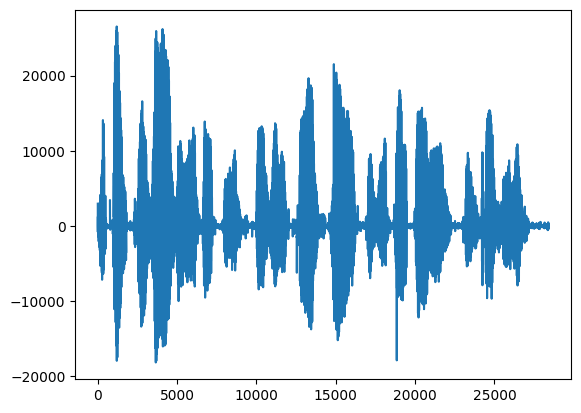

In [71]:
plt.plot(f)